In [1]:
from core._core_common_imports import *
import core.ModelClass as ModelClass
importlib.reload(ModelClass)
importlib.reload(ut)

from scipy.stats import binomtest


#### Prelims

In [11]:
# Define all directories and files
notebook_dir = os.path.dirname(os.getcwd()) # Project directory
run_name = 'run_2025-07-31-3'
# results_dir = os.path.join(notebook_dir, '..', 'Results', 'prefit_B', run_name)
results_dir = os.path.join(notebook_dir, 'Results', run_name)
data_dir = os.path.abspath(os.path.join(notebook_dir, 'Data', 'Processed'))

plots_dir = os.path.join(results_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

config_file = os.path.join(results_dir, 'config.yaml')
dataset_file = os.path.join(results_dir, 'dataset.h5')


In [12]:
# Load config
cfg = ut.load_config(config_file)    

# Define model

model = ModelClass.RAS_model(
    cfg.serogroup,
    cfg.mod_type,
    cfg.A,
    data_dir,
    cfg.year_groups,
    cfg.pandemic_years,
    cfg.risk,
    cfg.INCLUDE_VAX
)

# Variables
len_year_groups = np.array([len(ut.get_range_from_group(group)) for group in model.year_groups])
model.avg_IMD_data = (model.IMD_data / len_year_groups.reshape(-1,1)).astype(int)
years = np.arange(2019, 2024, 1)
n_years = len(years)


### 2019-2023

In [13]:
ut.h5file_view_elements(dataset_file)
attributes_dict, dataset_dict = ut.h5file_export(dataset_file)

bounds = attributes_dict['bounds']
n_param_sets = attributes_dict['n_param_sets']
param_names = list(attributes_dict['param_names'])

IMD_ll = dataset_dict['IMD_ll']
avg_mod_IMD = dataset_dict['avg_mod_IMD']
mod_carr_inc = dataset_dict['mod_carr_inc']
mod_carr_prev = dataset_dict['mod_carr_prev']
param_sets = dataset_dict['param_sets']

# all_years = False
all_years = True


IMD_ll <HDF5 dataset "IMD_ll": shape (127976,), type "<f8">
avg_mod_IMD <HDF5 dataset "avg_mod_IMD": shape (127976, 5, 5), type "<f8">


mod_carr_inc <HDF5 dataset "mod_carr_inc": shape (127976, 3, 101, 5), type "<f8">
mod_carr_prev <HDF5 dataset "mod_carr_prev": shape (127976,), type "<f8">
param_sets <HDF5 dataset "param_sets": shape (127976, 7), type "<f8">

Attributes:
bounds: [[ 0.00000000e+00  3.00000000e-01]
 [ 2.08330000e-02  2.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  7.47130018e+01]
 [ 0.00000000e+00  9.99999999e+00]
 [-6.20216087e+00  0.00000000e+00]]
n_param_sets: 127976
param_names: ['beta' 'delta_duration' 'zeta2020' 'zeta2021' 'a' 'b' 'c']


In [ ]:
# # Check parameter space for best ll_IMD. Confirm that they have non zero carriage prevalence
# n_best = 10
# sel_indices = np.argsort(IMD_ll)[::-1][:n_best]
# sel_param_sets = param_sets[sel_indices]

# risk_param_names = ['a', 'b', 'c']

# for param_set in sel_param_sets:
#     param_dict = dict(zip(param_names, param_set))
#     param_dict['Trotter_params'] = [param_dict.pop(risk_param_name) for risk_param_name in risk_param_names]
#     model.update_params(param_dict)
#     print(model.mod_params)
#     # model.simulate(end_year=2023, threshold_MSE=1)
#     # print(model.mod_carriage[0])


#### Preliminary plots

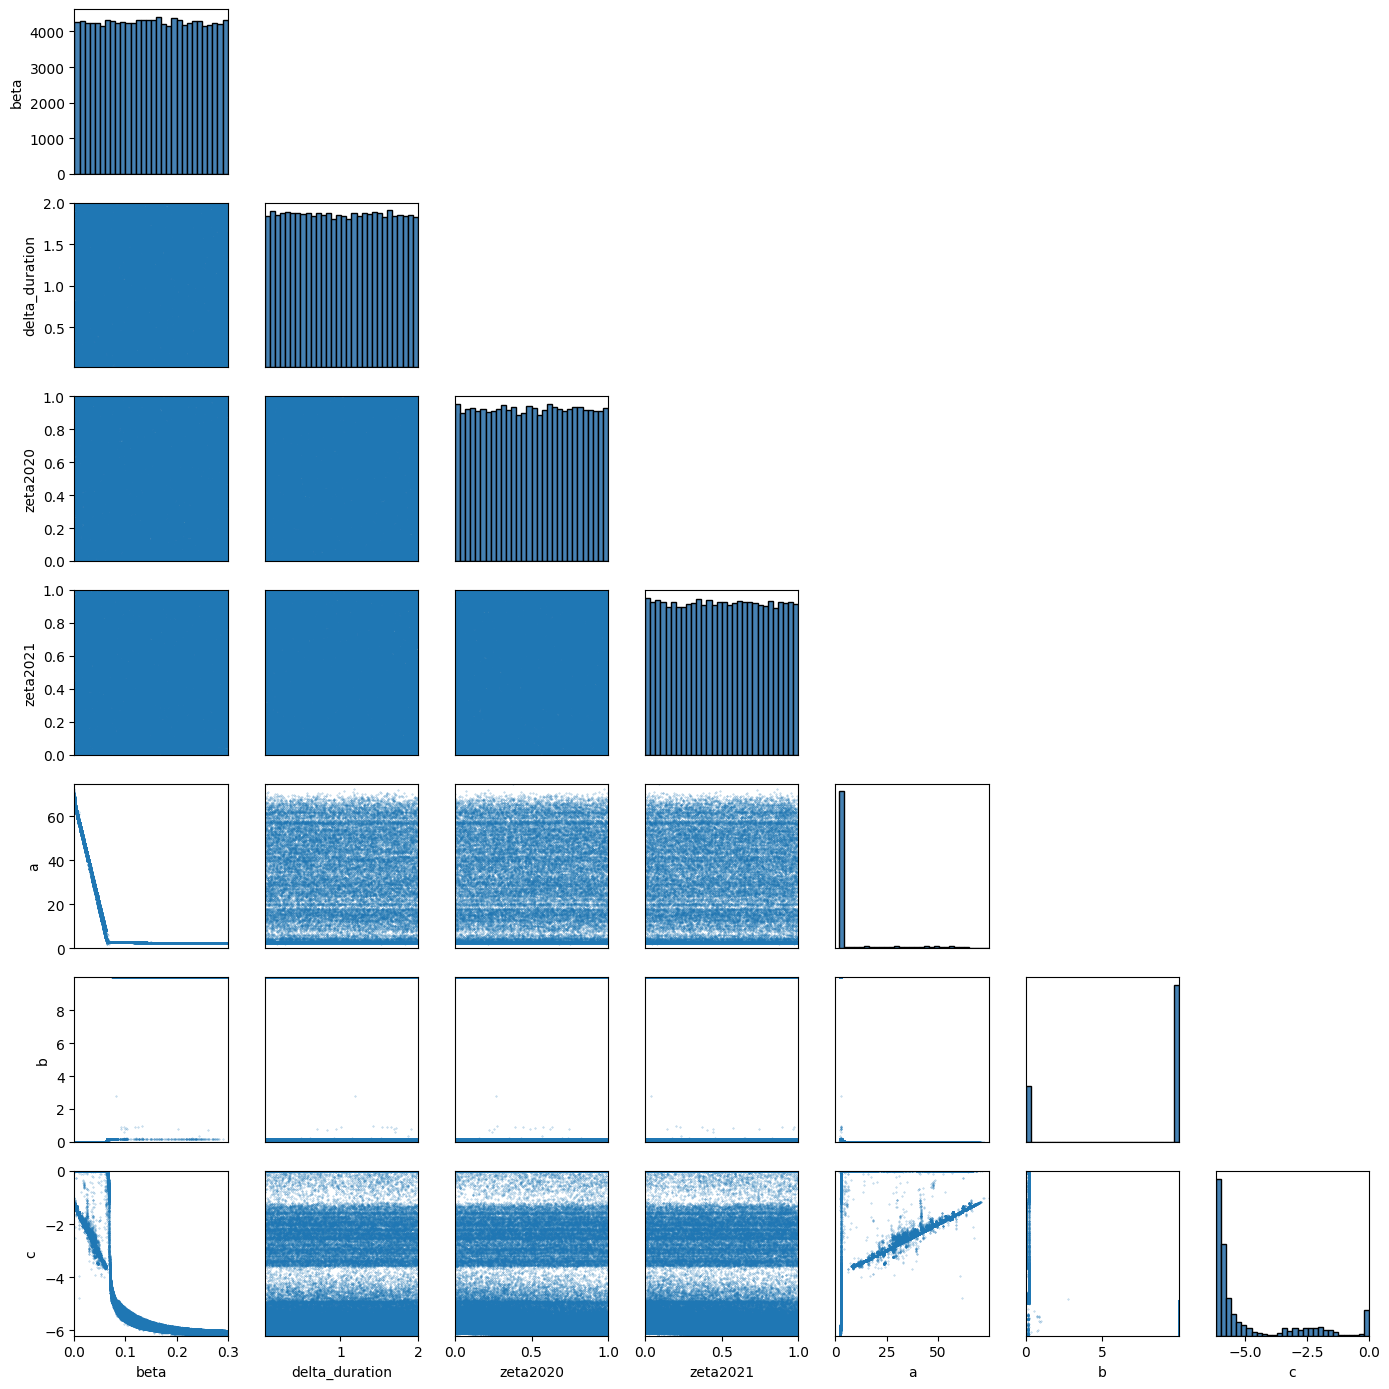

In [ ]:
# # Corner plot with no filters first
# limits_dict = {key:limits for key, limits in zip(param_names, bounds)}

# ut.plot_corner(
#     param_array=param_sets,
#     param_names=param_names,
#     limits=limits_dict,
#     s=0.1,
#     alpha=0.5,
#     save_path=os.path.join(plots_dir, f'corner_plot_no_filters'),
#     figsize=(14,14),
# )


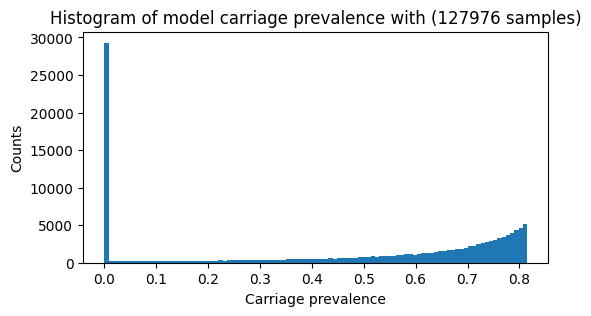

In [ ]:
# # Plot histogram of model carriage prevalence (with no filters, all samples)
# counts, bins = np.histogram(mod_carr_prev, bins=100)

# fig, ax = plt.subplots(1,1,figsize=(6,3))
# ax.hist(mod_carr_prev, bins)
# ax.set_title(f'Histogram of model carriage prevalence with ({n_param_sets} samples)')
# ax.set_xlabel('Carriage prevalence')
# ax.set_ylabel('Counts')
# fig.savefig(os.path.join(plots_dir, f'carriage_prevalence_hist'), bbox_inches='tight')
# plt.show()


#### Fit

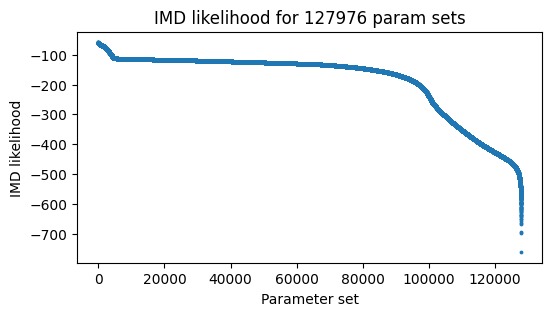

In [17]:
# Plot IMD likelihood

fig, ax = plt.subplots(1,1,figsize=(6,3))
# lim = True
lim = False
n_lim = 200 if lim else n_param_sets
ax.scatter(np.arange(n_lim), np.sort(IMD_ll)[::-1][:n_lim], s=3)
ax.set_xlabel('Parameter set')
ax.set_ylabel('IMD likelihood')
# ax.set_ylim(-1000,0)
ax.set_title(f'IMD likelihood for {n_param_sets} param sets')
filename = f'IMD_likelihood_2023_lim' if lim else f'IMD_likelihood_2023'
fig.savefig(os.path.join(plots_dir, filename), bbox_inches='tight')
plt.show()


In [18]:
# Check parameter space for best ll_IMD. Confirm that they have non zero carriage prevalence
n_best = 25
sel_indices = np.argsort(IMD_ll)[::-1][:n_best]


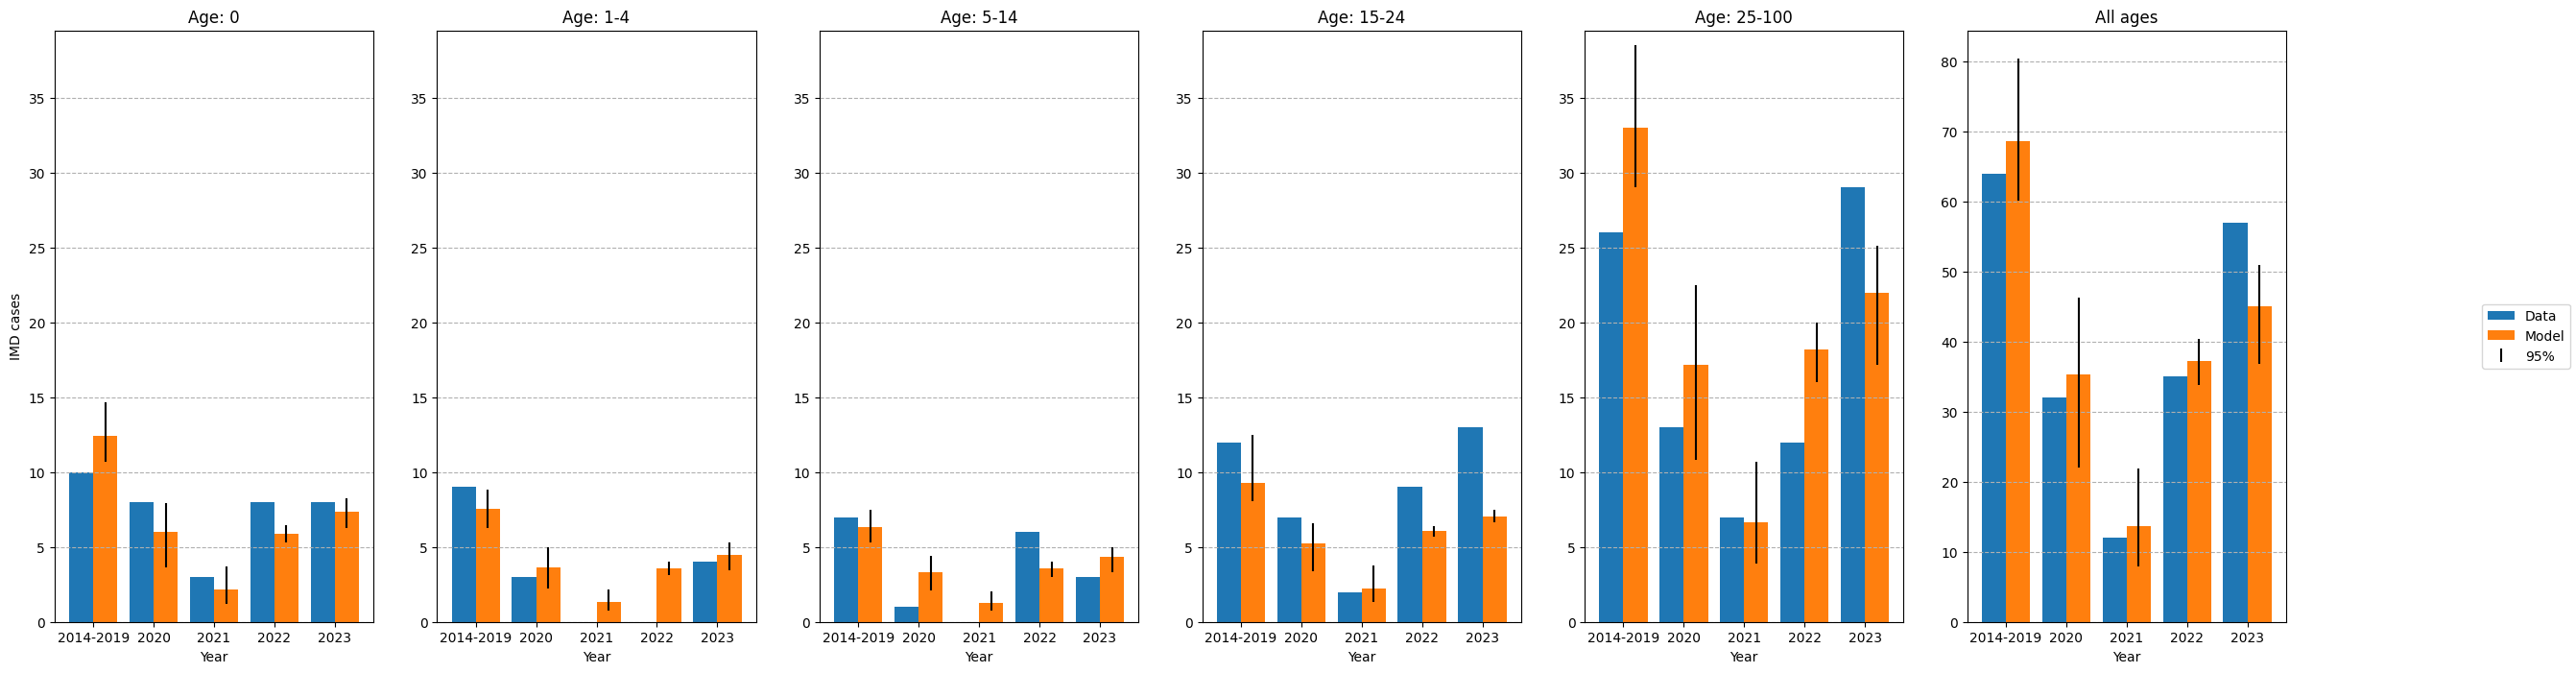

In [19]:
# Plot fit for best parameter sets

# Data
idx = ut.get_year_group_idx_from_year(2022, model.year_groups)
avg_IMD_data = model.avg_IMD_data
tot_IMD_data = np.sum(avg_IMD_data, axis=1)

# Model cases per age group
sel_avg_mod_IMD = avg_mod_IMD[sel_indices]
mean_mod_IMD = np.mean(sel_avg_mod_IMD, axis=0)
lower_mod_IMD = np.percentile(sel_avg_mod_IMD, 2.5, axis=0)
upper_mod_IMD = np.percentile(sel_avg_mod_IMD, 97.5, axis=0)

# Total cases
tot_mod_IMD = np.sum(sel_avg_mod_IMD, axis=2)
mean_tot_mod_IMD = np.mean(tot_mod_IMD, axis=0)
lower_tot_mod_IMD = np.percentile(tot_mod_IMD, 2.5, axis=0)
upper_tot_mod_IMD = np.percentile(tot_mod_IMD, 97.5, axis=0)

n_subplots = model.n_age_groups + 1
fig, axs = plt.subplots(1,n_subplots, figsize=(5*(n_subplots),8))
x_points = np.arange(n_years)
barwidth = 0.4
ymax = np.max([avg_IMD_data, upper_mod_IMD])

# Plot 2019-2023 for all age groups
for i in range(model.n_age_groups):
    ax = axs[i]
    ax.bar(x_points - barwidth / 2, avg_IMD_data[:,i], width=barwidth, label='Data')
    ax.bar(x_points + barwidth / 2, mean_mod_IMD[:,i], width=barwidth, label='Model')
    yerr_model = np.array([mean_mod_IMD[:,i] - lower_mod_IMD[:,i], upper_mod_IMD[:,i] - mean_mod_IMD[:,i]])
    ax.errorbar(x_points + barwidth / 2, mean_mod_IMD[:,i], yerr=yerr_model, color='black', label='95%', linestyle='none')

    # Plot elements
    ax.set_ylim(0,ymax+1)
    ax.set_title(f'Age: {model.age_groups[i]}')

# Total cases across all age groups
ax = axs[-1]
ax.bar(x_points - barwidth / 2, tot_IMD_data, width=barwidth, label='Data')
ax.bar(x_points + barwidth / 2, mean_tot_mod_IMD, width=barwidth, label='Model')
yerr_model = np.array([mean_tot_mod_IMD - lower_tot_mod_IMD, upper_tot_mod_IMD - mean_tot_mod_IMD])
ax.errorbar(x_points + barwidth / 2, mean_tot_mod_IMD, yerr=yerr_model, color='black', label='95%', linestyle='none')

# Plot elements
ax.set_title('All ages')

# Common elements for all subplots
for ax in axs:
    ax.set_xticks(x_points)
    ax.set_xticklabels(model.year_groups)
    ax.set_xlabel('Year')
    ax.grid(axis='y', linestyle='--')

axs[0].set_ylabel('IMD cases')
ut.create_single_legend(fig, axs, loc='outside right')
fig.savefig(os.path.join(plots_dir, f'IMD_cases'), bbox_inches='tight')
plt.show()


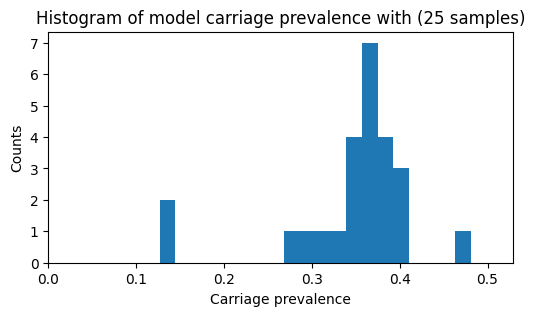

In [20]:
# Plot histogram of model carriage prevalence of best parameter sets
counts, bins = np.histogram(mod_carr_prev[sel_indices], bins=20)
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(mod_carr_prev[sel_indices], bins)
ax.set_title(f'Histogram of model carriage prevalence with ({n_best} samples)')
ax.set_xlabel('Carriage prevalence')
ax.set_xlim(0,np.max(mod_carr_prev[sel_indices]) * 1.1)
ax.set_ylabel('Counts')
fig.savefig(os.path.join(plots_dir, f'carriage_prevalence_hist_best_IMD_ll'), bbox_inches='tight')
plt.show()



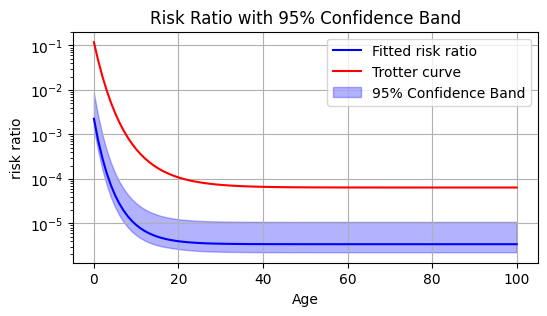

In [21]:
# Plot risk ratio curve for selected param sets
all_ages = np.arange(model.A)
risk_param_names = ['a', 'b', 'c']
risk_param_idx = [param_names.index(risk_param_name) for risk_param_name in risk_param_names]
risk_param_sets = param_sets[:,risk_param_idx]

sel_risk_param_sets = risk_param_sets[sel_indices]
risk_function_array = np.array([ut.CC_Trotter(all_ages, *risk_params) for risk_params in sel_risk_param_sets])

fig, ax = plt.subplots(1,1,figsize=(6, 3))

mean_risk = np.mean(risk_function_array, axis=0)
lower_risk = np.percentile(risk_function_array, 2.5, axis=0)
upper_risk = np.percentile(risk_function_array, 97.5, axis=0)

# Plot
ax.plot(all_ages, mean_risk, label='Fitted risk ratio', color='blue')
ax.plot(all_ages, model.mod_params['r'], label='Trotter curve', color='red')
ax.fill_between(all_ages, lower_risk, upper_risk, color='blue', alpha=0.3, label='95% Confidence Band')
ax.set_xlabel('Age')
ax.set_ylabel('risk ratio')
ax.set_yscale('log')
ax.set_title(f'Risk Ratio with 95% Confidence Band')
ax.legend()
ax.grid(True)

fig.savefig(os.path.join(plots_dir, f'risk_ratio_best_IMD_ll'))
plt.show()


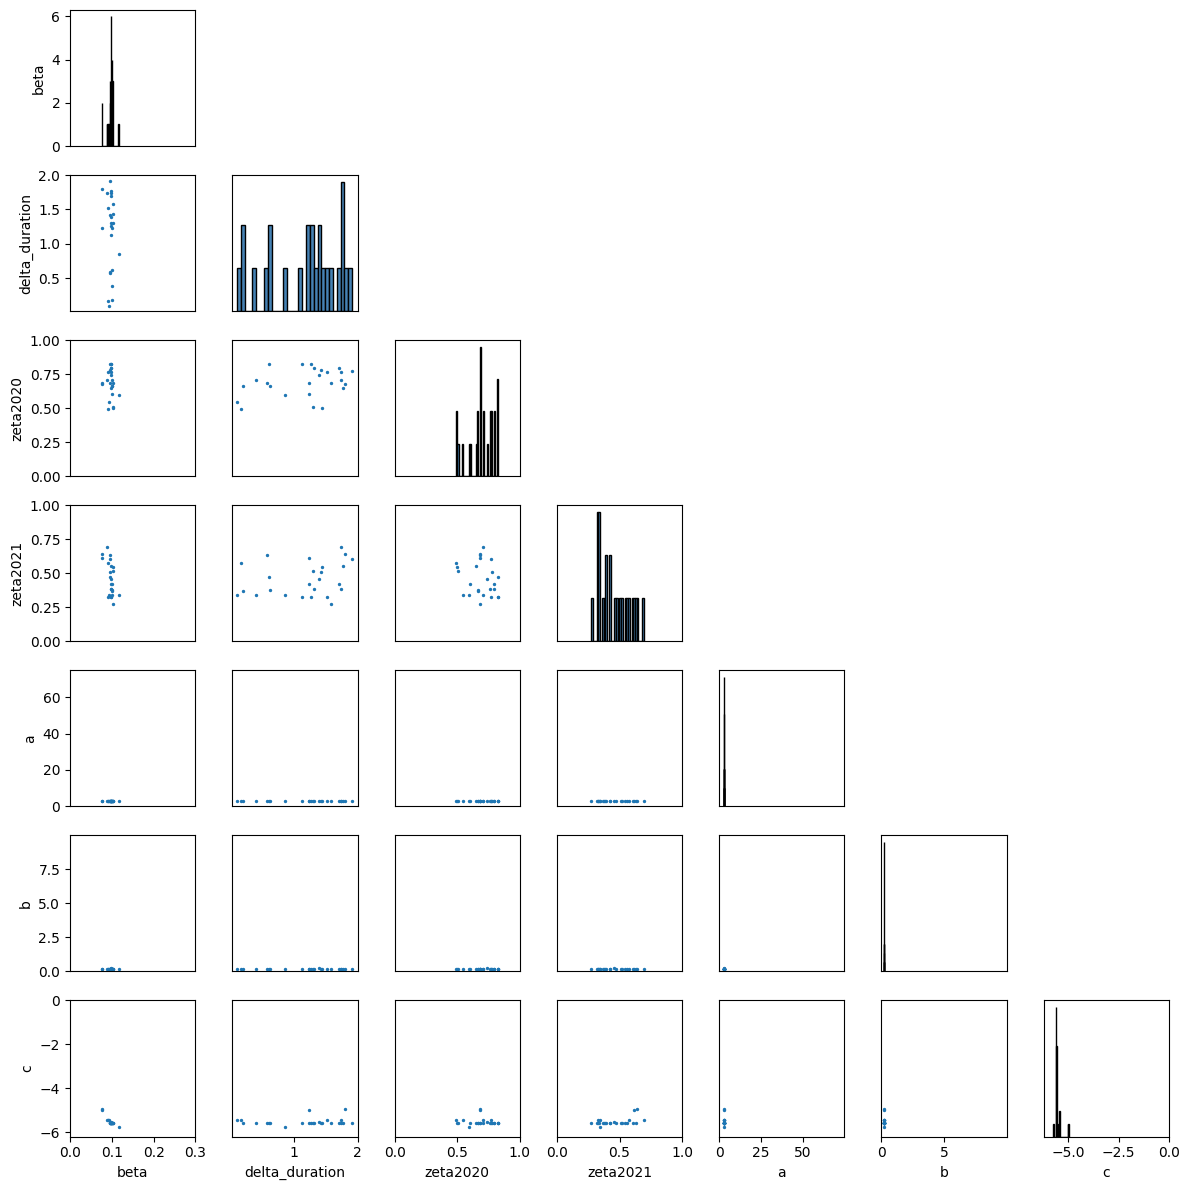

In [22]:
# Corner plot
ut.plot_corner(
    param_array=param_sets[sel_indices], 
    param_names=param_names, 
    limits=limits_dict, 
    s=2,
    alpha=1,
    save_path=os.path.join(plots_dir, f'corner_plot_best_IMD_ll'),
    figsize=(12,12),
)
